In [6]:
# Pour le travail sur les données
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import ceil

# Pour ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

# Pour PyTorch
from torch import Tensor, zeros
from torch.nn import Module, LSTM, Linear, MSELoss
from torch.optim import Adam

# Pour Darts
from darts import TimeSeries
from darts.models.forecasting.tide_model import TiDEModel

# Pour l'évaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Pour les graphiques
import matplotlib.pyplot as plt

# Pour supprimer les warnings et le logging intempestif
import warnings
import logging
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

# Classe fait maison pour afficher la progression lors des étapes qui prennent du temps
from utils import Stopwatch

In [7]:
# Fonction de division des données

def train_test_split(df, ratio):
    pivot = int(df.shape[0] * ratio)
    
    train = df.iloc[:pivot]
    test = df.iloc[pivot:]

    return train, test

In [8]:
# Fonction de création de sous-ensembles features et target (X et Y)

def x_y_split(df, nb_rows):
    data = np.array(df)
    size = data.shape[0]
    
    X = [data[i - nb_rows:i] for i in range(nb_rows, size)]
    Y = [data[i] for i in range(nb_rows, size)]

    return np.array(X), np.array(Y)

In [9]:
# Fonction pour grapher deux arrays et les comparer

def graph(y1, y2):
    time_steps = np.arange(0, len(y1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, y1, label="Original Data")
    plt.plot(time_steps, y2, label="Predicted Data", linestyle="--")
    plt.title("Original Data VS. Predicted Data")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# ARIMA

In [10]:
# Import des données

df = pd.read_pickle("./data/source.pkl")["APPLE"]  # Import du dataset
df = df.filter(["close"])                          # Selection de la colonne "close"

df.tail()

,close
date,
2025-04-14,202.52
2025-04-15,202.14
2025-04-16,194.27
2025-04-17,196.98
2025-04-21,193.16


In [11]:
# Normalisation des données

scaler = MinMaxScaler((0, 1))
df["close"] = scaler.fit_transform(df)

In [12]:
# Fonction pour ajouter du "lag"

def add_lag(df, target, num_rows):
    df = df.copy()
    for i in range(1, num_rows + 1):
        df[f"lag{i}"] = df[target].shift(num_rows * i)
    return df

# Fonction pour augmenter la résolution de l"information temporelle

def create_features(df):
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.dayofyear
    df["dayofmonth"] = df.index.day
    df["weekofyear"] = df.index.isocalendar().week
    return df

# Utilisation des fonctions

df = add_lag(df, "close", 12)        # On rajoute 12 colonnes, pour 12 points passés
df = create_features(df)             # On créé des colonnes pour essayer de mettre en valeur une cyclicité dans la temporalité

In [13]:
# Création des deux sous-ensembles

ratio = 0.8
train, test = train_test_split(df, ratio)

print(df.shape)
print(train.shape)
print(test.shape)

(3848, 20)
(3078, 20)
(770, 20)


In [14]:
# Recherche du meilleur ordre des variables pour le modèle Arima

stepwise_fit = auto_arima(train["close"], trace=True, suppress_warnings=True)
best_order = stepwise_fit.get_params()["order"]

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-22134.525, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-23119.082, Time=0.27 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.57 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-23427.652, Time=0.20 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-23653.568, Time=0.32 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-23836.600, Time=0.88 sec
 ARIMA(5,2,0)(0,0,0)[0]             : AIC=-23891.402, Time=0.37 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=-23915.899, Time=0.68 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-24208.198, Time=1.43 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=1.25 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=-24182.364, Time=1.65 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-24298.721, Time=1.07 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=inf, Time=1.86 sec
 ARIMA(2,2,1)(0,0,0)[0]          

In [15]:
# Entrainement du modèle Arima

arima = ARIMA(train["close"], order=best_order)
arima = arima.fit()

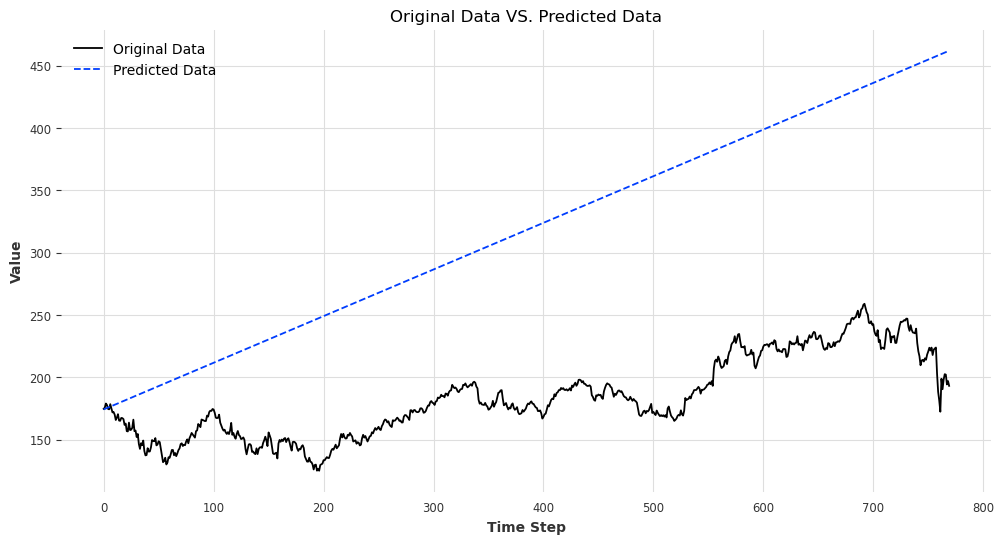

MSE: 21455.45338648567 | MAE: 134.66472345738148


In [16]:
# Prédictions

pivot = int(df.shape[0] * ratio)
predicted = arima.predict(start=pivot, end=df.shape[0]-1)

# Dénormalisation

predicted = scaler.inverse_transform(np.reshape(predicted, (predicted.shape[0], 1))) 
original = scaler.inverse_transform(np.reshape(test["close"], (test["close"].shape[0], 1))) 

# Evaluation

mse_arima = mean_squared_error(original, predicted)
mae_arima = mean_absolute_error(original, predicted)

# On graphe les deux arrays

graph(original, predicted)

print(f"MSE: {mse_arima} | MAE: {mae_arima}")


# LSTM avec PyTorch

In [17]:
# Définition des constantes

NB_ROWS = 60

# Pour le réseau de neuronnes
INPUT_DIM = 1
HIDDEN_DIM = 100
LAYER_DIM = 1
OUTPUT_DIM = 1

# Pour l'entraînement
LR = 0.01
EPOCHS = 100

In [18]:
# Import des données

df = pd.read_pickle("./data/source.pkl")["APPLE"]
df.tail()

,open,high,low,close,volume
date,,,,,
2025-04-14,211.44,212.94,201.16,202.52,101352911
2025-04-15,201.86,203.51,199.80,202.14,51343900
2025-04-16,198.36,200.70,192.37,194.27,59732423
2025-04-17,197.20,198.83,194.42,196.98,52164675
2025-04-21,193.27,193.80,189.81,193.16,45860324


In [19]:
# Choix de la variable

df = df.filter(["close"])               

# Normalisation

scaler = MinMaxScaler((0, 1))
df["close"] = scaler.fit_transform(df)

In [20]:
# Division en sous-ensembles features-target

X, Y = x_y_split(df["close"], NB_ROWS)

# Changement de type pour PyTorch

X = Tensor(X[:,:,None])
Y = Tensor(Y[:,None])

# Vérification

print(df["close"].shape)
print(X.shape)
print(Y.shape)

(3848,)
torch.Size([3788, 60, 1])
torch.Size([3788, 1])


In [21]:
# Définition de la classe qui représente le réseau de neuronnes

class LSTMModel(Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.lstm = LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = Linear(
            in_features=hidden_size,
            out_features=output_size,
        )

    def forward(self, x, h0, c0):
        y, (h1, c1) = self.lstm(x, (h0, c0))
        y = self.fc(y[:, -1, :])
        return y, h1, c1

In [22]:
# Instanciation du réseau de neuronnes

model = LSTMModel(INPUT_DIM, HIDDEN_DIM, LAYER_DIM, OUTPUT_DIM)

# Méthode d'évaluation pour l'entraînement

criterion = MSELoss()

# Algorithme d'optimisation d'entrainement
# Plus d'infos ici : https://arxiv.org/abs/1412.6980

optimizer = Adam(model.parameters(), lr=LR)

In [23]:
# Initialisation des variables d'état

blank = zeros(LAYER_DIM, X.shape[0], HIDDEN_DIM).to("cpu")  # Des zéros
h0 = blank                                                        # Etat caché
c0 = blank                                                        # Etat pas caché

# Lancement de l'entrainement
timer = Stopwatch()
timer.start(EPOCHS)

for i in range(EPOCHS):
    model.train()                                   # On passe le modèle en "mode entraînement"
    optimizer.zero_grad()                           # Réinitialisation des attributs de l'optimisateur
    
    outputs, h0, c0 = model(X, h0, c0)              # Entrainement n°i
    
    loss = criterion(outputs, Y)                    # Evaluation des résultats
    loss.backward()                                 # Calcul du gradient
    optimizer.step()                                # Mise à jour des poids

    h0 = h0.detach()
    c0 = c0.detach()

    if (i + 1) % ceil(EPOCHS / 10) == 0:
        timer.info(step=i)
        print(f'Loss: {loss.item():.5f}')

timer.stop()

Elapsed: 00:00:06 | Remaining: 00:01:02 	 [9.00%]
Loss: 0.07336
Elapsed: 00:00:11 | Remaining: 00:00:49 	 [19.00%]
Loss: 0.04250
Elapsed: 00:00:16 | Remaining: 00:00:41 	 [29.00%]
Loss: 0.02433
Elapsed: 00:00:21 | Remaining: 00:00:34 	 [39.00%]
Loss: 0.00429
Elapsed: 00:00:27 | Remaining: 00:00:28 	 [49.00%]
Loss: 0.00263
Elapsed: 00:00:32 | Remaining: 00:00:22 	 [59.00%]
Loss: 0.00086
Elapsed: 00:00:38 | Remaining: 00:00:17 	 [69.00%]
Loss: 0.00085
Elapsed: 00:00:43 | Remaining: 00:00:11 	 [79.00%]
Loss: 0.00043
Elapsed: 00:00:48 | Remaining: 00:00:05 	 [89.00%]
Loss: 0.00036
Elapsed: 00:00:53 | Remaining: 00:00:00 	 [99.00%]
Loss: 0.00028


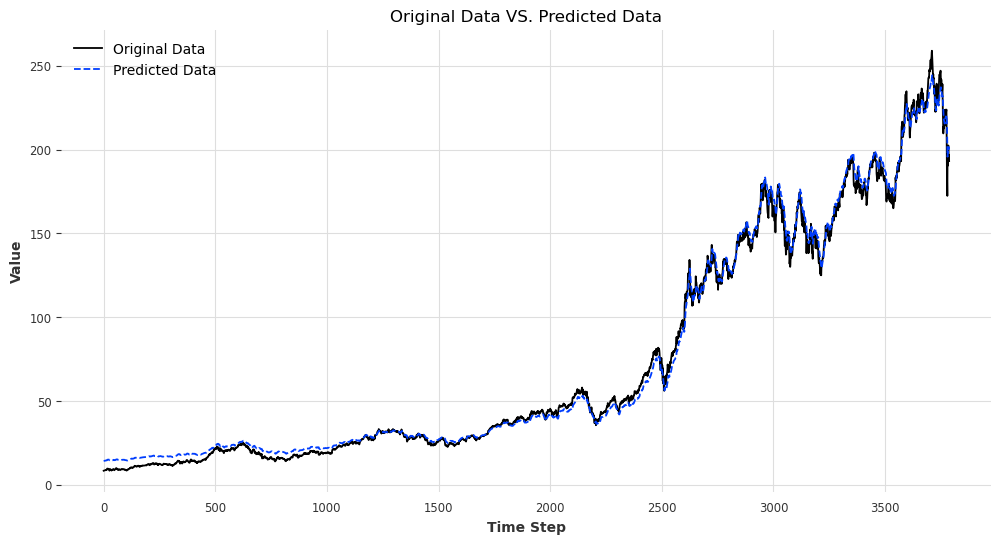

MSE: 17.584081649780273 | MAE: 3.296443462371826


In [25]:
model.eval()

# Prédiction

predicted, _, _ = model(X, h0, c0)

# Dénormalisation

predicted = scaler.inverse_transform(predicted.detach().numpy())
original = scaler.inverse_transform(np.array(Y))

# Evaluation

mse_lstm = mean_squared_error(original, predicted)
mae_lstm = mean_absolute_error(original, predicted)

# On graphe les deux arrays

graph(original, predicted)

print(f"MSE: {mse_lstm} | MAE: {mae_lstm}")


# TiDE avec Darts

In [26]:
# Importation des données

pickle = pd.read_pickle("./data/source.pkl")

# Rangement des données

names = list(pickle.keys())                                                     # Liste des noms d'entreprises
dataframes = [values.filter(["close"]) for (key, values) in pickle.items()]     # Liste des dataframes

In [27]:
# Normalisation des données

scaler = MinMaxScaler((0, 1))

for df in dataframes:
    df["close"] = scaler.fit_transform(df)

In [28]:
# Séparation des données

test_set = TimeSeries.from_values(dataframes[0])                                       # Le cours d'Apple
train_sets = [TimeSeries.from_values(dataframe[1:]) for dataframe in dataframes]       # Tout les autres

In [29]:
# Définition des constantes

INPUT_LEN = 60
OUTPUT_LEN = 1
LAYER_DIM = 100
BATCH_SIZE = 32
EPOCHS = 100

In [30]:
# Définition du modèle

model = TiDEModel(
    input_chunk_length=INPUT_LEN,
    output_chunk_length=OUTPUT_LEN,
    hidden_size=LAYER_DIM,
    batch_size=BATCH_SIZE,            # On définit la batch_size directement ici
    n_epochs=EPOCHS,                  # De même pour les epochs
    model_name="Stonks",
    force_reset=True,
)

In [31]:
# Entrainement du modèle
# Pas besoin de rajouter des boucles car on a déjà définit batch_size et n_epochs

model.fit(
    train_sets
)

Training: |                                                                                      | 0/? [00:00<…

TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=100, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=60, output_chunk_length=1, batch_size=32, n_epochs=100, model_name=Stonks, force_reset=True)

In [35]:
# Prédiction
# On effectue un grand nombre de prédictions uniques à la suite pour composer avec nos données originales

size = len(test_set) - INPUT_LEN
predicted = []                                     # Serie de predictions

timer.start(size)
for i in range(0, size):
    data_slice = test_set[i:i+INPUT_LEN]           # On crée des tranches de données de la même taille que lors de l'entraînement
    prediction = model.predict(
        n=1,                                       # Une seule prediction
        series=data_slice,                         # Sur la base d'une tranche de données "glissante"
        verbose=False,
        show_warnings=False
    )
    predicted.append(prediction.values()[-1,0])    # On ajoute la prediction aux autres

    # Pour afficher la progression (chaque 10%)
    if (i % int(size / 10)) == 0:
        timer.info(step=i+1)

timer.stop()

# Au cas où on fait une mauvaise manip'
save = predicted

Elapsed: 00:00:00 | Remaining: 00:07:23 	 [0.03%]
Elapsed: 00:00:30 | Remaining: 00:04:36 	 [10.01%]
Elapsed: 00:01:01 | Remaining: 00:04:05 	 [19.98%]
Elapsed: 00:01:32 | Remaining: 00:03:35 	 [29.96%]
Elapsed: 00:02:03 | Remaining: 00:03:05 	 [39.94%]
Elapsed: 00:02:33 | Remaining: 00:02:34 	 [49.92%]
Elapsed: 00:03:04 | Remaining: 00:02:03 	 [59.90%]
Elapsed: 00:03:36 | Remaining: 00:01:33 	 [69.88%]
Elapsed: 00:04:07 | Remaining: 00:01:02 	 [79.86%]
Elapsed: 00:04:45 | Remaining: 00:00:32 	 [89.84%]
Elapsed: 00:05:20 | Remaining: 00:00:00 	 [99.82%]


In [36]:
# On réajuste le scaler qui était resté réglé sur le min et le max de la 7ème entreprise (à cause de la boucle)
scaler.fit(pickle["APPLE"].filter(["close"]))

# Dénormalisation 
original = np.array(test_set.values())
original = scaler.inverse_transform(np.reshape(original, (original.shape[0], 1)))[INPUT_LEN:]
predicted = scaler.inverse_transform(np.reshape(predicted, (len(predicted), 1)))

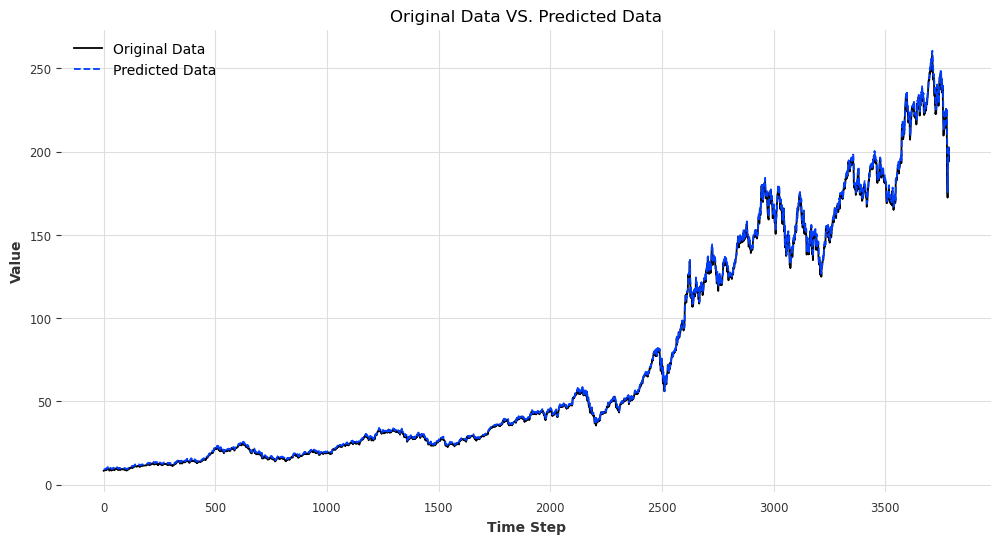

MSE: 4.449692923474248 | MAE: 1.3534091802557509


In [37]:
START = 0
END = -1

# On graphe les deux arrays

graph(original[START:END], predicted[START:END])

# Evaluation

mse_tide = mean_squared_error(original, predicted)
mae_tide = mean_absolute_error(original, predicted)

print(f"MSE: {mse_tide} | MAE: {mae_tide}")

# TiDE avec Darts
#### (Avec du feature engineering)

Malheuresement, je n'ai pas eu le temps de faire fonctionner le modèle. (J'ai tenté T-T)

In [58]:
# Importation des données

pickle = pd.read_pickle("./data/processed.pkl")

In [59]:
# Rangement des données

names = list(pickle.keys())                                                     # Liste des noms d'entreprises
dataframes = [values for (key, values) in pickle.items()]                       # Liste des dataframes

In [60]:
# Le jeu de données est bien (trop) fourni
# On retire les colonnes "open", "high" et "low", qui sont trop fortement corrélées avec "close" et qui ne rajoutent pas d'information

for dataframe in dataframes:
    dataframe.drop(columns = ["open", "high", "low"], inplace = True)

In [61]:
# Normalisation

scaler = MinMaxScaler((0, 1))

for dataframe in dataframes:
    dataframe = scaler.fit_transform(dataframe)

In [74]:
# Division des features et past covariates

features = []
past_covs = []

for dataframe in dataframes:
    features.append(dataframe.filter(["close"]))
    past_covs.append(dataframe.drop(columns=["close"]))

In [82]:
# Séparation des données

nb = len(features)

test_features = TimeSeries.from_values(features[0])
test_covariates = TimeSeries.from_values(past_covs[0])

train_features = [TimeSeries.from_values(feature) for feature in features]
train_covariates = [TimeSeries.from_values(past_cov) for past_cov in past_covs]

In [83]:
# (Re)Définition du modèle

model = TiDEModel(
    input_chunk_length=INPUT_LEN,
    output_chunk_length=OUTPUT_LEN,
    hidden_size=LAYER_DIM,
    batch_size=BATCH_SIZE,            # On définit la batch_size directement ici
    n_epochs=EPOCHS,                  # De même pour les epochs
    model_name="Stonks",
    force_reset=True,
)

# Entrainement du modèle

model.fit(
    series=train_features,
    past_covariates=train_covariates
)

Training: |                                                                                      | 0/? [00:00<…

TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=100, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=60, output_chunk_length=1, batch_size=32, n_epochs=100, model_name=Stonks, force_reset=True)

In [85]:
# Prédiction
# On effectue un grand nombre de prédictions uniques à la suite pour composer avec nos données originales

size = len(test_features) - INPUT_LEN
predicted = []                                             # Serie de predictions

timer.start(size)
for i in range(0, size):
    features_slice = test_features[i:i+INPUT_LEN]          # Tranches de features
    covariates_slice = test_covariates[i:i+INPUT_LEN]      # Tranches de covariates
    
    prediction = model.predict(
        n=1,
        series=features_slice,
        past_covariates=covariates_slice,
        verbose=False,
        show_warnings=False
    )
    predicted.append(prediction.values()[-1,0])    # On ajoute la prediction aux autres

    # Pour afficher la progression (chaque 10%)
    if (i % int(size / 10)) == 0:
        timer.info(step=i+1)

timer.stop()

# Au cas où on fait une mauvaise manip'
save = predicted

Elapsed: 00:00:00 | Remaining: 00:08:45 	 [0.03%]
Elapsed: 00:00:34 | Remaining: 00:05:09 	 [10.01%]
Elapsed: 00:01:08 | Remaining: 00:04:33 	 [20.00%]
Elapsed: 00:01:41 | Remaining: 00:03:57 	 [29.99%]
Elapsed: 00:02:14 | Remaining: 00:03:22 	 [39.97%]
Elapsed: 00:02:49 | Remaining: 00:02:49 	 [49.96%]
Elapsed: 00:03:22 | Remaining: 00:02:15 	 [59.95%]
Elapsed: 00:03:55 | Remaining: 00:01:41 	 [69.93%]
Elapsed: 00:04:28 | Remaining: 00:01:07 	 [79.92%]
Elapsed: 00:05:00 | Remaining: 00:00:33 	 [89.91%]
Elapsed: 00:05:33 | Remaining: 00:00:00 	 [99.89%]


In [104]:
predicted = save

In [100]:
# On réajuste le scaler qui était resté réglé sur le min et le max de la 7ème entreprise (à cause de la boucle)
scaler.fit(pickle["APPLE"].filter(["close"]))

# Dénormalisation 
# original = np.array(test_set.values())
# original = scaler.inverse_transform(np.reshape(original, (original.shape[0], 1)))[INPUT_LEN:]
# predicted = scaler.inverse_transform(np.reshape(predicted, (len(predicted), 1)))

# original = np.array(test_features.values())
# original = scaler.inverse_transform(np.reshape(original, (original.shape[0], 1)))[INPUT_LEN:]
# predicted = scaler.inverse_transform(np.reshape(predicted, (len(predicted), 1)))

MinMaxScaler()

In [101]:
original = pickle["APPLE"].filter(["close"])[INPUT_LEN:]

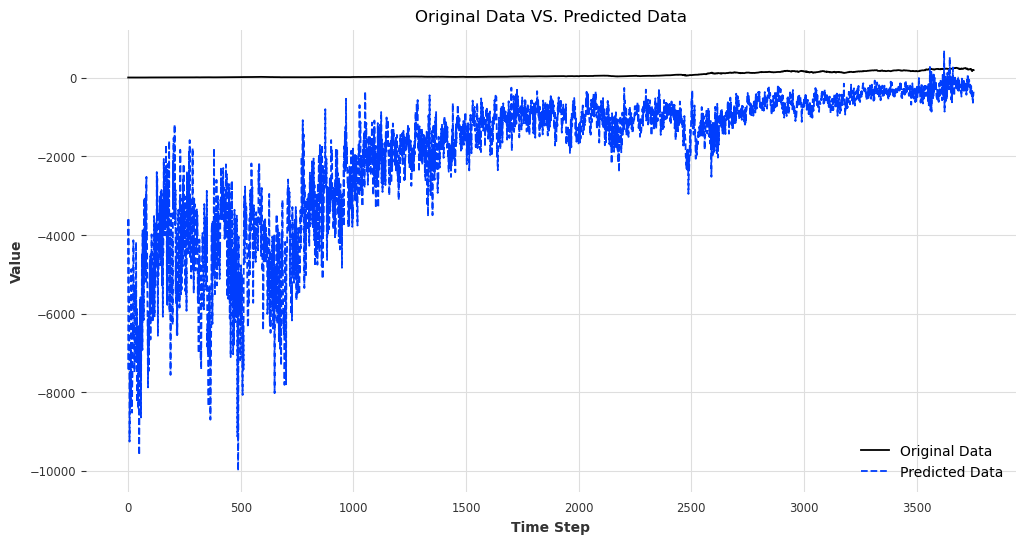

MSE: 6643387.583002859 | MAE: 1950.2007506165287


In [102]:
START = 0
END = -1

# On graphe les deux arrays

graph(original[START:END], predicted[START:END])

# Evaluation

mse_tide = mean_squared_error(original, predicted)
mae_tide = mean_absolute_error(original, predicted)

print(f"MSE: {mse_tide} | MAE: {mae_tide}")